In [1]:
# Import standard libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Load Data

In [2]:
# Move up one level to data, then access raw
file_path = '../data/raw/retail_sales_dataset.csv'

# Load the CSV file
retail_data = pd.read_csv(file_path)

# Display the first few rows of the data
print(retail_data.head())

   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100  


### Data Manipulation

In [3]:
import pandas as pd
import holidays

# Assuming retail_data['Date'] is a datetime column
retail_data['Date'] = pd.to_datetime(retail_data['Date'])

# Initialize Canadian holidays for 2023 and 2024
canadian_holidays = holidays.Canada(years=[2023, 2024])

# Create a column for whether the date is a holiday
retail_data['is_holiday'] = retail_data['Date'].dt.date.isin(canadian_holidays.keys())

# Alternatively, map the holiday name to the date, leaving NaN for non-holidays
retail_data['holiday_name'] = retail_data['Date'].dt.date.map(canadian_holidays).fillna('Not a holiday')

# Check the updated data
print(retail_data.head())



   Transaction ID       Date Customer ID  Gender  Age Product Category  \
0               1 2023-11-24     CUST001    Male   34           Beauty   
1               2 2023-02-27     CUST002  Female   26         Clothing   
2               3 2023-01-13     CUST003    Male   50      Electronics   
3               4 2023-05-21     CUST004    Male   37         Clothing   
4               5 2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  is_holiday   holiday_name  
0         3              50           150       False  Not a holiday  
1         2             500          1000       False  Not a holiday  
2         1              30            30       False  Not a holiday  
3         1             500           500       False  Not a holiday  
4         2              50           100       False  Not a holiday  


In [4]:
# Filter the data for holidays
holidays_data = retail_data[retail_data['is_holiday'] == True]

# Display the holidays and their corresponding names
print(holidays_data[['Date', 'holiday_name']])


          Date               holiday_name
77  2023-07-01                 Canada Day
162 2023-01-02  New Year's Day (observed)
179 2023-01-01             New Year's Day
210 2024-01-01             New Year's Day
259 2023-07-01                 Canada Day
296 2023-09-04                 Labour Day
302 2023-01-02  New Year's Day (observed)
420 2023-01-02  New Year's Day (observed)
454 2023-07-01                 Canada Day
521 2023-01-01             New Year's Day
558 2023-01-01             New Year's Day
649 2024-01-01             New Year's Day
756 2023-12-25              Christmas Day
836 2023-07-01                 Canada Day
978 2023-01-02  New Year's Day (observed)


In [5]:
# Add the month, quarter, and day of the week
retail_data['month'] = retail_data['Date'].dt.month
retail_data['quarter'] = retail_data['Date'].dt.quarter
retail_data['day_of_week'] = retail_data['Date'].dt.dayofweek  # 0=Monday, 6=Sunday

# Check after adding 'month', 'quarter', and 'day_of_week'
print(retail_data[['Date', 'month', 'quarter', 'day_of_week']].head())



        Date  month  quarter  day_of_week
0 2023-11-24     11        4            4
1 2023-02-27      2        1            0
2 2023-01-13      1        1            4
3 2023-05-21      5        2            6
4 2023-05-06      5        2            5


In [6]:
# Function to assign season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Create a 'season' column
retail_data['season'] = retail_data['month'].apply(get_season)

# Check the updated data
print(retail_data[['Date', 'season']].head())

        Date  season
0 2023-11-24    Fall
1 2023-02-27  Winter
2 2023-01-13  Winter
3 2023-05-21  Spring
4 2023-05-06  Spring


In [7]:
retail_data = retail_data.drop(columns=['season_Spring', 'season_Summer', 'season_Winter'], errors='ignore') # making sure these columns should not exist

In [8]:
print(retail_data.columns.tolist())  # Full list of column names


['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount', 'is_holiday', 'holiday_name', 'month', 'quarter', 'day_of_week', 'season']


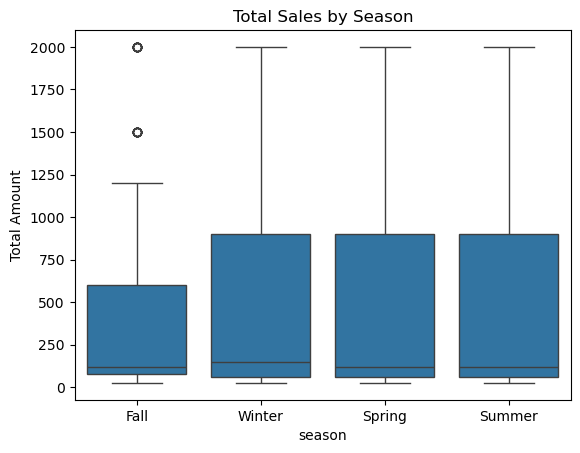

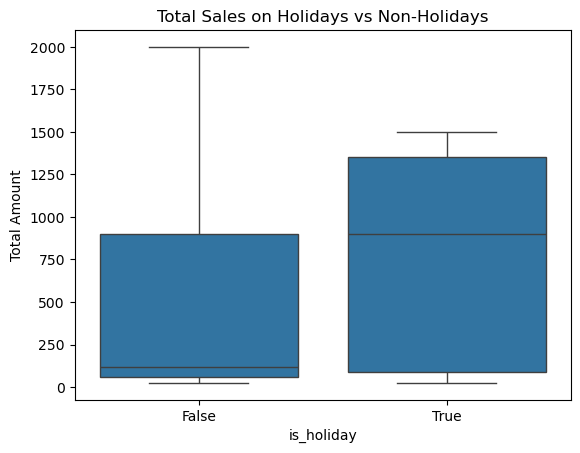

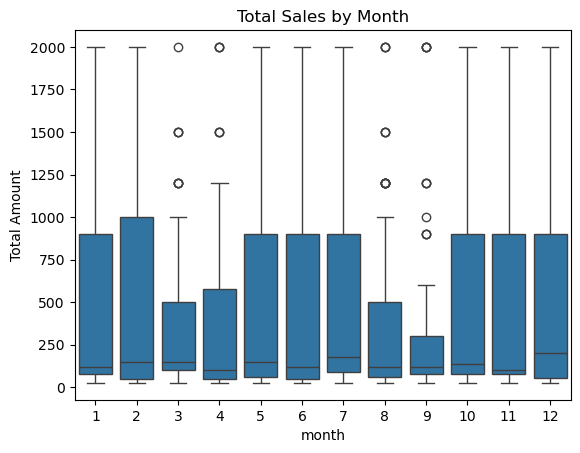

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot average sales by season
sns.boxplot(x='season', y='Total Amount', data=retail_data)
plt.title('Total Sales by Season')
plt.show()

# Plot sales on holidays vs non-holidays
sns.boxplot(x='is_holiday', y='Total Amount', data=retail_data)
plt.title('Total Sales on Holidays vs Non-Holidays')
plt.show()

# Plot sales by month
sns.boxplot(x='month', y='Total Amount', data=retail_data)
plt.title('Total Sales by Month')
plt.show()


### Feature Engineering

In [10]:
# Select relevant features (before one-hot encoding)
features = ['month', 'quarter', 'day_of_week', 'is_holiday']

# Convert 'season' to one-hot encoding and update the DataFrame
retail_data = pd.get_dummies(retail_data, columns=['season'], drop_first=True)

# Add the one-hot encoded 'season' columns to the features
season_columns = [col for col in retail_data.columns if col.startswith('season_')]
features.extend(season_columns)

# Define X (features) and y (target)
X = retail_data[features]
y = retail_data['Total Amount']

# Proceed with model training
print("Features used for training:", features)

Features used for training: ['month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter']


Before running the **SARIMA** model, we need to make sure 

- Double-check that all columns in X (features) and y (target variable, Total Amount) contain numeric data.
- If there are missing values (NaN), need to either fill them with appropriate values (like mean/median) or drop those rows.
- Ensure categorical columns (like is_holiday, and the one-hot encoded season_* columns) are correctly encoded as numerical values.

### Data Cleaning

In [ ]:

# Ensure there are no missing values in features and target
retail_data = retail_data.dropna(subset=['Total Amount', 'month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter'])

# Target variable: 'Total Amount'
y = retail_data['Total Amount']

# Features (X) for training the model
X = retail_data[['month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter']]

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Convert 'is_holiday' to a numeric type (1 for holiday, 0 for not)
X['is_holiday'] = X['is_holiday'].astype(int)

month            int32
quarter          int32
day_of_week      int32
is_holiday       int32
season_Spring    int32
season_Summer    int32
season_Winter    int32
dtype: object
int64


c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored w

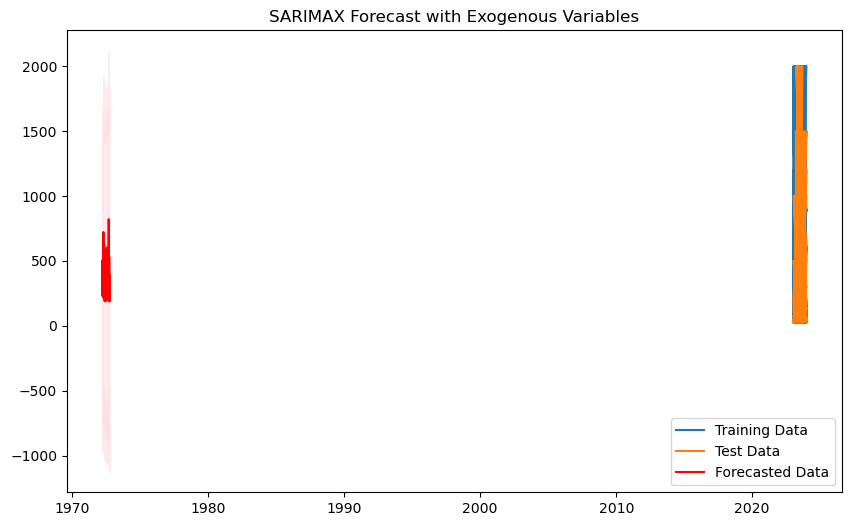

RMSE: 499.1230957851958


In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Drop any rows with missing values in Total Amount or features
retail_data = retail_data.dropna(subset=['Total Amount', 'month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter'])

# Make sure the target 'Total Amount' is numeric
retail_data['Total Amount'] = pd.to_numeric(retail_data['Total Amount'], errors='coerce')

# Convert boolean columns (seasons) to integers (0 for False, 1 for True)
retail_data['season_Spring'] = retail_data['season_Spring'].astype(int)
retail_data['season_Summer'] = retail_data['season_Summer'].astype(int)
retail_data['season_Winter'] = retail_data['season_Winter'].astype(int)

# Features (X) for training the model
X = retail_data[['month', 'quarter', 'day_of_week', 'is_holiday', 'season_Spring', 'season_Summer', 'season_Winter']]

# Ensure all features are numeric, explicitly convert to float if necessary
X = X.apply(pd.to_numeric, errors='coerce')

# Convert 'is_holiday' to integer (1 for holiday, 0 for not)
X['is_holiday'] = X['is_holiday'].astype(int)

# Target variable (y) - 'Total Amount'
y = retail_data['Total Amount']

# Check if all data types are numeric
print(X.dtypes)
print(y.dtypes)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(y) * 0.8)
train_y, test_y = y[:train_size], y[train_size:]
train_X, test_X = X[:train_size], X[train_size:]

# Step 1: Fit SARIMAX model with exogenous variables
sarimax_model = SARIMAX(train_y, 
                       exog=train_X,  # Add exogenous variables (features)
                       order=(1, 1, 1),  # Non-seasonal ARIMA parameters (p, d, q)
                       seasonal_order=(1, 1, 1, 12),  # Seasonal ARIMA parameters (P, D, Q, m=12 for monthly)
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

# Fit the model
sarimax_fit = sarimax_model.fit(disp=False)

# Step 2: Forecast the future
forecast_steps = len(test_y)  # Forecast for the test period
forecast = sarimax_fit.get_forecast(steps=forecast_steps, exog=test_X)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Step 3: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_y, label='Training Data')
plt.plot(test_y, label='Test Data')
plt.plot(forecast_mean, label='Forecasted Data', color='red')
plt.fill_between(forecast_mean.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.show()

# Step 4: Evaluate the model (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test_y, forecast_mean))
print(f"RMSE: {rmse}")


In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

# TimeSeriesSplit cross-validation (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=5)

# Define a list to store RMSE scores for each fold
rmse_scores = []

# Loop over each split in cross-validation
for train_index, test_index in tscv.split(X):
    # Split the data into training and test sets based on the current fold
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]
    
    # Fit SARIMAX model
    sarimax_model = SARIMAX(train_y, 
                           exog=train_X,  # Exogenous features
                           order=(1, 1, 1),  # Non-seasonal parameters (p, d, q)
                           seasonal_order=(1, 1, 1, 12),  # Seasonal parameters (P, D, Q, m=12 for monthly data)
                           enforce_stationarity=False, 
                           enforce_invertibility=False)
    
    # Fit the SARIMAX model
    sarimax_fit = sarimax_model.fit(disp=False)
    
    # Forecast for the test period
    forecast = sarimax_fit.get_forecast(steps=len(test_y), exog=test_X)
    forecast_mean = forecast.predicted_mean
    
    # Calculate RMSE for the current fold
    rmse = np.sqrt(mean_squared_error(test_y, forecast_mean))
    rmse_scores.append(rmse)

# Print RMSE for each fold and the average RMSE
print(f"RMSE for each fold: {rmse_scores}")
print(f"Average RMSE: {np.mean(rmse_scores)}")


c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\satis\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored w

RMSE for each fold: [753.5789035838496, 607.9299078888336, 589.6640688545693, 565.1489706909601, 522.0454413238208]
Average RMSE: 607.6734584684067
